In [1]:
#!/usr/bin/env python
# coding: utf-8

In [2]:
import os
import sys
import time
import argparse
import scanpy as sc
import pertpy as pt
import numpy as np
import pandas as pd
from scipy import stats, sparse
# from scipy.special import gaussian
from scipy.spatial.distance import cosine as cosine_dist, cdist
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from collections import OrderedDict
from lightning.pytorch import Trainer, seed_everything

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
## CLI
#python script.py input_data.h5ad \
# --outdir run1 \
#  --celltype_col my_celltype_column \
#  --condition_col treatment_group \
#  --control_val untreated \
#  --stimulated_val treated \
#  --downsample 500 \
#  --use_scvi \
#  --top_k 100 \
#  --use_csr \
#  --seed 42 \
#  --deterministic \
#  --de_methods t-test wilcoxon logreg \
#  --de_majority_vote

In [4]:
# === ARGUMENT PARSING ===
parser = argparse.ArgumentParser(description="Run perturbation prediction pipeline on an AnnData object.")
parser.add_argument("input_file", type=str, help="Path to the input .h5ad file")
parser.add_argument("--downsample", type=int, default=3000, help="Number of cells to randomly retain (optional)")
parser.add_argument("--celltype_col", type=str, default="cell_type", help="Column in .obs containing cell type info")
parser.add_argument("--seed", type=int, default=42, help="Random seed for reproducibility")
parser.add_argument("--deterministic", action="store_true", help="Enable deterministic training in Lightning")
parser.add_argument("--condition_col", type=str, default="condition", help="Column in .obs indicating stimulation condition")
parser.add_argument("--control_val", type=str, default="control", help="Value in condition_col indicating control condition")
parser.add_argument("--stimulated_val", type=str, default="stimulated", help="Value in condition_col indicating stimulated condition")
parser.add_argument("--use_csr", action="store_true", help="Convert matrix to CSR format for speed (default: False)")
parser.add_argument("--top_k", type=int, default=100, help="Number of top DEGs to compare (default: 100)")
parser.add_argument("--use_scvi", action="store_true", help="Use 'scvi_normalized' layer as .X (skips Scanpy normalization)")
parser.add_argument("--de_methods", nargs="+", default=["t-test"], choices=["t-test", "wilcoxon", "logreg"], help="DE methods to combine (for majority voting)")
parser.add_argument("--de_majority_vote", action="store_true", help="Use majority vote (instead of union) for combining DEGs")
parser.add_argument("--outdir", type=str, default="run1", help="Output directory to store results and figures (default: run1)")

_StoreAction(option_strings=['--outdir'], dest='outdir', nargs=None, const=None, default='run1', type=<class 'str'>, choices=None, required=False, help='Output directory to store results and figures (default: run1)', metavar=None)

In [5]:
args, unknown = parser.parse_known_args()

In [6]:
# === Setup output paths before redirection ===
outdir = args.outdir
figdir = os.path.join(outdir, "figures")
os.makedirs(figdir, exist_ok=True)

In [7]:
# === Now safe to print ===
sc.settings.figdir = figdir
# Apply seed
seed_everything(args.seed, workers=True)

Seed set to 42


42

In [8]:
## CONFIGURATION
USE_CSR = args.use_csr
K = args.top_k
print(f"Using CSR: {USE_CSR}, Top-K DEGs: {K}")
input_file = args.input_file
downsample_n = args.downsample
celltype_col = args.celltype_col

Using CSR: False, Top-K DEGs: 100


In [9]:
# Load and normalize dataset accordingly
train = sc.read("qc_filtered_bhattacherjee.h5ad")

In [10]:
# If using scVI-normalized data, set it as the main matrix
if args.use_scvi:
    if "scvi_normalized" not in train.layers:
        raise ValueError("Requested --use_scvi, but 'scvi_normalized' layer not found in AnnData.")
    train.X = train.layers["scvi_normalized"]
    print("Using 'scvi_normalized' layer as .X (no Scanpy normalization).")
else:
    sc.pp.normalize_total(train)
    print("Applied Scanpy normalization to .X")
    
train.raw = train.copy()
norm_data = train

Applied Scanpy normalization to .X


In [11]:
# Optional downsampling
if downsample_n is not None:
    print(f"Downsampling to {downsample_n} cells")
    idx = np.random.choice(norm_data.obs_names, size=downsample_n, replace=False)
    norm_data = norm_data[idx].copy()

Downsampling to 3000 cells


In [12]:
# # Rename celltype and condition columns
# if celltype_col != "cell_type":
#     norm_data.obs.rename(columns={celltype_col: "cell_type"}, inplace=True)
# if args.condition_col != "label":
#     norm_data.obs.rename(columns={args.condition_col: "label"}, inplace=True)

In [13]:
# Map the condition values to 'ctrl' and 'stim'
norm_data.obs["label"] = norm_data.obs["label"].map(
    lambda x: "ctrl" if x == "Maintenance_Cocaine" else "stim" if x in ["withdraw_15d_Cocaine", "withdraw_48h_Cocaine"] else np.nan
)

In [14]:
print(norm_data.obs["label"].value_counts())

label
stim    2302
ctrl     698
Name: count, dtype: int64


In [15]:
# Optional cast to CSR
if USE_CSR and sparse.issparse(norm_data.X):
    norm_data.X = norm_data.X.tocsr()

In [16]:
# === Metric helpers ===
def mean_var_kde_distance(X1, X2, bandwidth=1.0, grid_size=50):
    m1, v1 = X1.mean(0), X1.var(0)
    m2, v2 = X2.mean(0), X2.var(0)
    pts1, pts2 = np.vstack([m1, v1]).T, np.vstack([m2, v2]).T
    mins, maxs = np.minimum(pts1.min(0), pts2.min(0)), np.maximum(pts1.max(0), pts2.max(0))
    xs = np.linspace(mins[0], maxs[0], grid_size)
    ys = np.linspace(mins[1], maxs[1], grid_size)
    grid = np.vstack(np.meshgrid(xs, ys)).reshape(2, -1).T
    kde1 = KernelDensity(bandwidth=bandwidth).fit(pts1)
    kde2 = KernelDensity(bandwidth=bandwidth).fit(pts2)
    d1 = np.exp(kde1.score_samples(grid))
    d2 = np.exp(kde2.score_samples(grid))
    dx, dy = xs[1]-xs[0], ys[1]-ys[0]
    return float(np.abs(d1 - d2).sum() * dx * dy)

def bootstrap_metrics(X, real_mask, pred_mask, pca_coords, n_boot=100, frac=0.8, seed=0):
    rng = np.random.default_rng(seed)
    r_idx = np.where(real_mask)[0]
    p_idx = np.where(pred_mask)[0]
    s_r, s_p = max(1, int(frac*len(r_idx))), max(1, int(frac*len(p_idx)))
    keys = ["R2","MSE","RMSE","MAE","L2","Pearson","Cosine","Edist","MMD","Euc"]
    vals = {k: [] for k in keys}
    for _ in range(n_boot):
        r = rng.choice(r_idx, s_r, replace=True)
        p = rng.choice(p_idx, s_p, replace=True)
        Y = X[r].mean(0)
        Xp = X[p].mean(0)
        d = Xp - Y
        vals["MSE"].append(np.mean(d**2))
        vals["RMSE"].append(np.sqrt(np.mean(d**2)))
        vals["MAE"].append(np.mean(np.abs(d)))
        vals["L2"].append(np.linalg.norm(d))
        vals["Pearson"].append(stats.pearsonr(Xp, Y)[0])
        vals["Cosine"].append(1 - cosine_dist(Xp, Y))
        ss_res = ((Y - Xp)**2).sum()
        ss_tot = ((Y - Y.mean())**2).sum()
        vals["R2"].append(1 - ss_res/ss_tot if ss_tot > 0 else np.nan)
        Pr, Pp = pca_coords[r], pca_coords[p]
        vals["Euc"].append(np.linalg.norm(Pr.mean(0) - Pp.mean(0)))
        d_rr = pairwise_distances(Pr, Pr)
        d_pp = pairwise_distances(Pp, Pp)
        d_rp = pairwise_distances(Pr, Pp)
        vals["Edist"].append(2*d_rp.mean() - d_rr.mean() - d_pp.mean())
        Krr = np.exp(-cdist(Pr, Pr,'sqeuclidean')/2)
        Kpp = np.exp(-cdist(Pp, Pp,'sqeuclidean')/2)
        Krp = np.exp(-cdist(Pr, Pp,'sqeuclidean')/2)
        vals["MMD"].append(Krr.mean() + Kpp.mean() - 2*Krp.mean())
    stats_out = {}
    for k in keys:
        arr = np.array(vals[k])
        stats_out[f"{k}_mean"] = arr.mean()
        stats_out[f"{k}_std"] = arr.std()
    return stats_out

def compute_dist_scaled(X, ctrl_mask, stim_mask, pred_mask, eps=1e-8):
    m_ctrl = X[ctrl_mask].mean(0)
    m_stim = X[stim_mask].mean(0)
    m_pred = X[pred_mask].mean(0)
    ok = ~np.isnan(m_ctrl) & ~np.isnan(m_stim) & ~np.isnan(m_pred)
    d_in = np.linalg.norm(m_ctrl[ok] - m_stim[ok])
    d_pr = np.linalg.norm(m_pred[ok] - m_stim[ok])
    return d_pr / (d_in + eps)

Testing Excitatory


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 1/5:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:369: You have overridden `transfer_batch_to_device` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.


Epoch 5/5: 100%|██████████| 5/5 [00:35<00:00,  6.38s/it, train_loss_step=1.87e+4, train_loss_epoch=5.48e+4]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [00:35<00:00,  7.18s/it, train_loss_step=1.87e+4, train_loss_epoch=5.48e+4]


/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/tmp/ipykernel_497/2554641053.py:35: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  eval_adata = ctrl.concatenate(stim, pred)
/usr/local/lib/python3.10/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


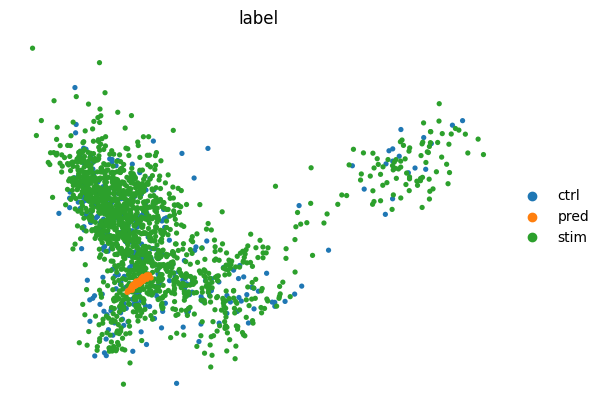

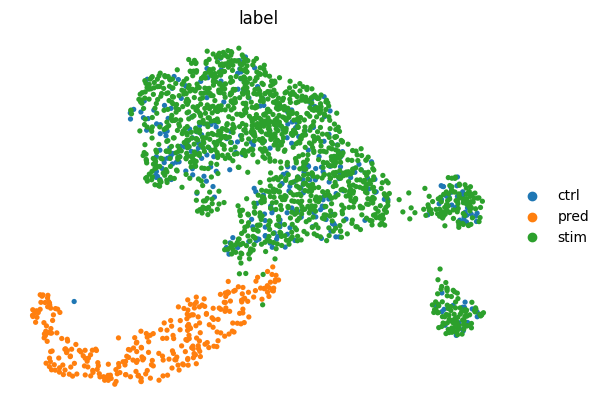

Running DE with method: t-test
('stim',)
('pred',)
100 genes used (union of top-100 DEGs from all methods)
Top 100 stim vs ctrl DE genes:
  ['Clta', 'Cox5a', 'Cck', 'Cyc1', 'Atxn7l3b', 'Tmem93', 'Rab3a', 'Gde1', '2310036O22Rik', '2310044H10Rik', 'Ndufab1', 'Npdc1', 'Mrps34', 'Snf8', 'Mlf2', 'Zfp593', 'Slc25a3', 'Tspan17', 'Fbxl15', 'Pde6d', 'Mrps26', 'Mrfap1', 'Tmem66', 'Rtn1', 'Stub1', 'Rprml', 'Pfn1', 'Tomm20', 'Mrps15', 'Pop5', 'Gm16517', 'Fbxo2', 'Phb2', 'Camk1', 'Itm2b', 'Apoe', 'Grin2a', 'Thoc3', 'Rheb', 'Rab14', 'Nudt19', 'Rab11a', 'Gadd45gip1', 'Yeats4', 'Tmem42', 'Glrx2', 'Trappc6b', 'Ccdc85b', 'Arhgdig', 'Dut', 'Slc2a8', 'Cxx1a', 'Gm1673', 'Lsm4', 'Zcrb1', 'Upf3a', 'Rell2', 'Cadm1', 'Fkbp1a', 'Pacsin1', 'Nrgn', 'Mtdh', 'Rasl11b', 'Zfp428', 'Gabbr1', 'Rnf112', 'Junb', 'Slc16a11', 'Chst1', 'Yjefn3', 'Tmem70', 'Eif5a', 'Krt12', 'Nol7', 'Tspan3', 'Tmem203', '1500011H22Rik', '6330407J23Rik', 'Fdx1l', 'Tpst2', 'Ubxn4', 'Gm16869', '1810049H13Rik', 'Usp2', 'Nudc', 'Actr3', 'Med9', 'C

/usr/local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


Testing Oligo
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 5/5: 100%|██████████| 5/5 [01:10<00:00, 13.58s/it, train_loss_step=6.41e+3, train_loss_epoch=3.52e+4]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [01:10<00:00, 14.05s/it, train_loss_step=6.41e+3, train_loss_epoch=3.52e+4]


/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/tmp/ipykernel_497/2554641053.py:35: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  eval_adata = ctrl.concatenate(stim, pred)
/usr/local/lib/python3.10/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


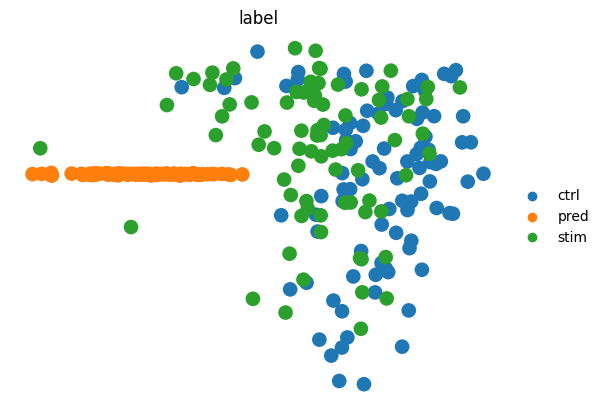

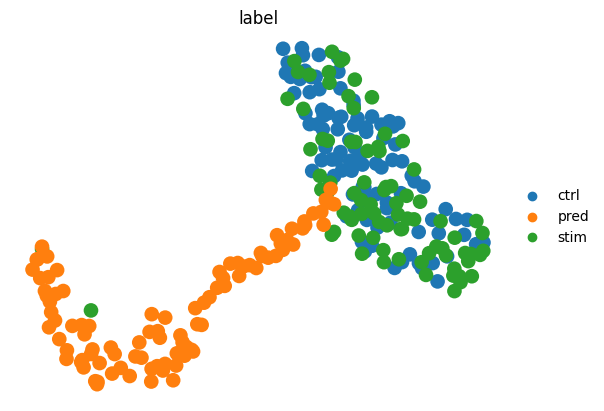

Running DE with method: t-test
('stim',)
('pred',)
100 genes used (union of top-100 DEGs from all methods)
Top 100 stim vs ctrl DE genes:
  ['Yipf3', 'Gde1', 'Cck', 'Rnaseh2c', 'Akr7a5', 'Stmn2', 'Rtn1', 'Rab3a', '6330407J23Rik', 'Nfe2l1', 'Nudt18', 'Cntn1', 'Hmbs', 'Hsd17b7', 'Alg5', 'Ap2s1', 'Ostf1', 'Clta', 'Flywch1', 'Caly', 'Pin1', 'Mrps34', 'Klf13', 'Ddx1', 'Snap25', 'Cyc1', 'Pik3ca', 'Fxyd6', 'Dctn1', 'Tef', 'Endod1', 'BC004004', 'Mrfap1', '1810029B16Rik', 'Mcam', 'Lphn1', 'Ngly1', 'Gusb', 'Bdh1', 'Rnf138', 'Mpzl1', 'BC088983', 'Arhgap32', 'Coq4', 'Atxn7l3b', 'Pdxk', 'Tmem42', 'Cox5a', 'Sncb', 'Per3', 'Poldip2', 'Sgcb', 'Acox3', 'Tm2d1', 'Wdr45', 'Tmem66', 'Rtn3', 'Matr3', 'Nipsnap1', 'Pnmal2', 'Safb2', 'Osgin2', 'Polr3e', 'Fibp', 'Glrx2', 'Gars', 'Fam175b', 'Rcl1', 'Lrrc41', 'Vps18', 'Srrm2', '2700078E11Rik', 'Phldb1', 'Tollip', 'Snhg12', '2310044H10Rik', 'Sidt2', 'Fkbp8', 'Cdipt', 'Tspyl2', '2410066E13Rik', 'Ctbp1', 'Gkap1', 'Tmod1', 'Unc5b', 'Psmd13', 'Abcb10', 'Rab14', 'Ptpn

/usr/local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


Testing Astro
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/usr/local/lib/python3.10/site-packages/scvi/dataloaders/_data_splitting.py:258: UserWarning: 2 cells moved from training set to validation set. if you want to avoid it please use train_size parameter during train.
  self.n_train, self.n_val = validate_data_split(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/site-packages/lightni

Epoch 5/5: 100%|██████████| 5/5 [01:06<00:00, 13.04s/it, train_loss_step=3.78e+4, train_loss_epoch=3.47e+4]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [01:06<00:00, 13.38s/it, train_loss_step=3.78e+4, train_loss_epoch=3.47e+4]


/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/tmp/ipykernel_497/2554641053.py:35: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  eval_adata = ctrl.concatenate(stim, pred)
/usr/local/lib/python3.10/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


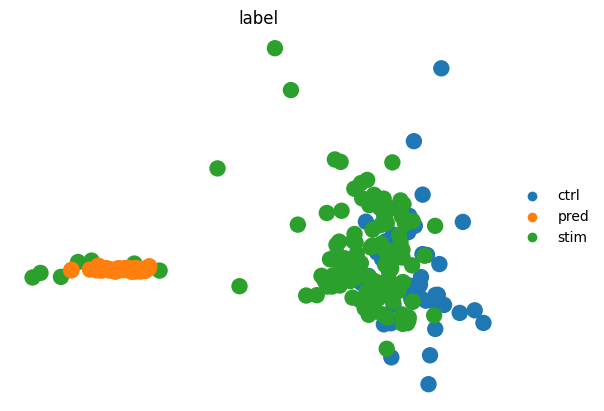

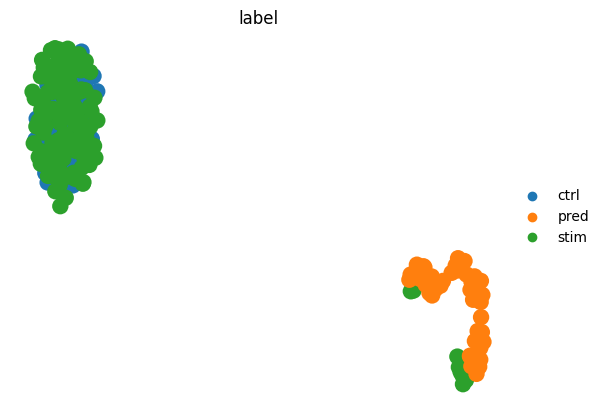

Running DE with method: t-test
('stim',)
('pred',)
100 genes used (union of top-100 DEGs from all methods)
Top 100 stim vs ctrl DE genes:
  ['Cck', 'Cox5a', 'Specc1', 'Snap25', 'Katna1', 'Mrpl46', '5031425E22Rik', '1110008J03Rik', 'Uxt', 'Bcl2l2', 'Stx1a', 'Zfp422', 'Vps53', 'Ppp1r3g', 'Atp1a1', 'Naa15', 'Resp18', 'Cables1', 'Nfe2l1', 'Syt4', 'Ppp1r1b', 'Spsb3', 'Stmn2', 'Slu7', 'Bin1', 'Ptprn', 'Tbpl1', 'Ypel3', 'Trub2', 'Psme3', 'Psmd9', 'Scamp5', 'Apoa1bp', 'Pigk', 'Nmi', 'Got2', 'Fam58b', 'Nr2c2ap', 'Stmn3', 'Nt5c3', 'Rian', 'Cd3eap', 'Snx3', 'Prkce', 'Sirt2', 'Smyd3', 'Rab3a', 'Bex4', 'Tmem214', 'Angptl6', 'Coro1a', 'Bzw1', '1810043G02Rik', 'Nsg2', 'Fgf13', 'Arpc1a', 'Ppp1r1a', 'Fam96a', 'Tmem35', '2700089E24Rik', 'Scg2', 'Zfhx2', 'Eif3b', 'Zfp451', 'Zfp944', 'Ncaph2', 'Scarb2', 'Snrpn', 'Arih1', 'Mkl2', 'Xrcc1', 'Trappc6b', 'Neurod6', 'Cdc27', 'Cnot6l', 'Tpm1', '1190002H23Rik', 'Clta', 'Atad3a', 'Ndufab1', 'Arid5b', 'Tmem56', 'App', 'Rcor3', 'Vangl2', 'Nmt2', 'Gfap', 'Cog8', '250

/usr/local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


Testing Microglia
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/usr/local/lib/python3.10/site-packages/scvi/dataloaders/_data_splitting.py:258: UserWarning: 1 cells moved from training set to validation set. if you want to avoid it please use train_size parameter during train.
  self.n_train, self.n_val = validate_data_split(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/site-packages/lightni

Epoch 5/5: 100%|██████████| 5/5 [01:08<00:00, 13.28s/it, train_loss_step=3.23e+4, train_loss_epoch=3.41e+4]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [01:08<00:00, 13.74s/it, train_loss_step=3.23e+4, train_loss_epoch=3.41e+4]


/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/tmp/ipykernel_497/2554641053.py:35: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  eval_adata = ctrl.concatenate(stim, pred)
/usr/local/lib/python3.10/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


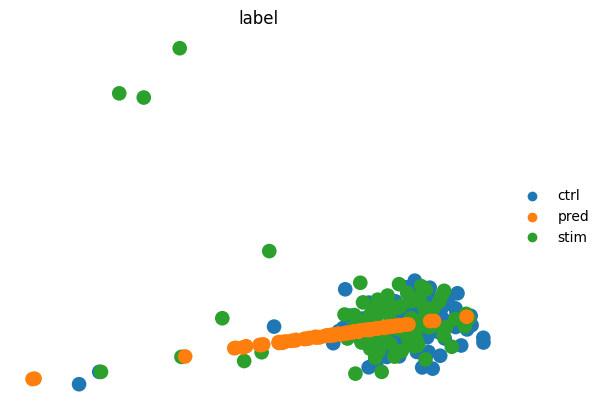

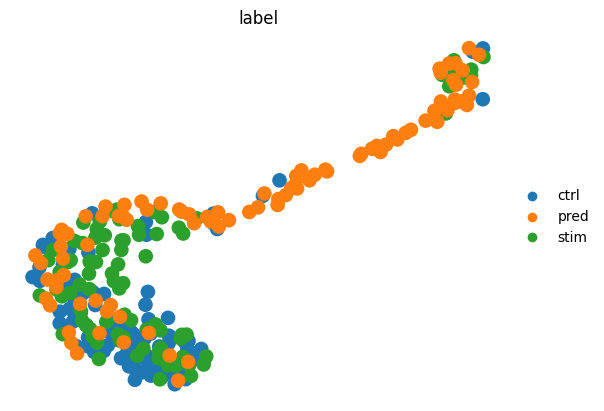

Running DE with method: t-test
('stim',)
('pred',)
100 genes used (union of top-100 DEGs from all methods)
Top 100 stim vs ctrl DE genes:
  ['Snx1', 'Eif4e', 'Tuba1b', 'Rpf1', 'Ebp', 'Hbxip', 'Akap8', 'Fdx1l', 'Errfi1', 'Vapa', 'Smad2', 'Yme1l1', 'Dcp1b', 'Mbtd1', 'Fez1', 'Eif4e2', 'Ndufa8', 'Pdia6', 'Rgs1', 'Exosc5', 'Ranbp3', 'Psmd6', 'Atp5c1', 'Hdac3', 'Lrba', 'Sf3a3', 'Sar1b', 'Sept6', 'Fcgr4', 'Arpc5', 'Vps37a', 'Ahsa1', 'Cox19', 'Echs1', 'Farsb', 'Ciapin1', 'Ostc', 'Psma2', 'Commd7', 'Dusp5', 'Gpbp1', 'Arl5c', 'Cck', 'Mmgt1', 'Ccdc50', 'Galnt7', 'Bag5', 'Dram2', 'Hbegf', 'Gtl3', 'Cdc26', 'Dnaja1', 'Ints12', 'Polr1e', 'Eif3a', 'Ifitm3', 'Exosc4', 'Ict1', 'Cmtm3', 'Usp14', 'Mapk9', 'Ilkap', 'Jagn1', 'Mrpl35', 'Ormdl1', 'Hint2', 'Zwint', 'Npl', 'Myd88', 'C130022K22Rik', '1110058L19Rik', 'Napa', 'Cisd1', 'Crip1', 'Acp1', 'Kars', 'Ifrd2', 'G530011O06Rik', 'Dars', 'Atp6v1b2', 'Ccl24', 'Mtap7d1', 'Clk3', 'Meg3', 'Lsm1', 'Cnbp', 'Cyc1', 'Scp2', 'Nfs1', 'Prdx4', 'Pbrm1', 'Rhoc', 'Gins4', 

/usr/local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


Testing Inhibitory
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 5/5: 100%|██████████| 5/5 [01:08<00:00, 13.14s/it, train_loss_step=2.67e+4, train_loss_epoch=3.61e+4]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [01:08<00:00, 13.65s/it, train_loss_step=2.67e+4, train_loss_epoch=3.61e+4]


/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/tmp/ipykernel_497/2554641053.py:35: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  eval_adata = ctrl.concatenate(stim, pred)
/usr/local/lib/python3.10/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


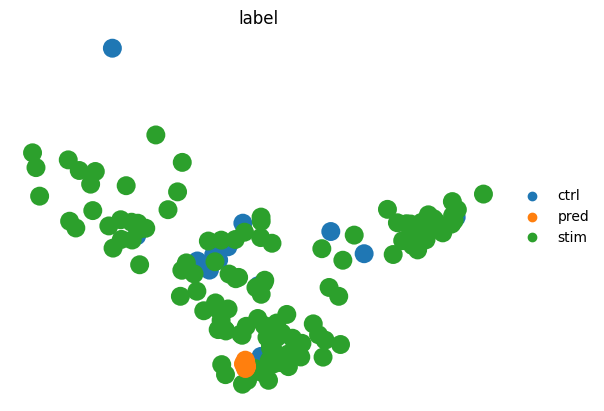

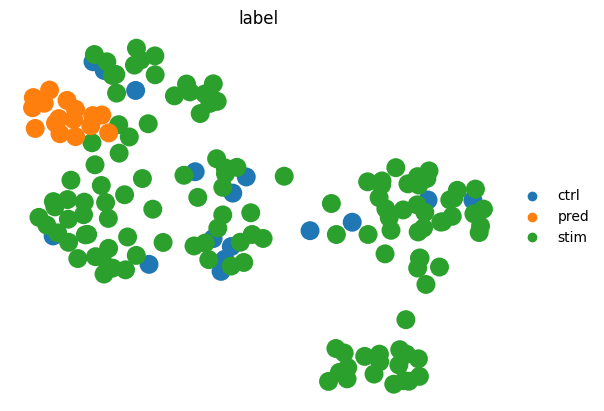

Running DE with method: t-test
('stim',)
('pred',)
100 genes used (union of top-100 DEGs from all methods)
Top 100 stim vs ctrl DE genes:
  ['Ehmt2', 'Twf1', 'Pde4dip', 'Zdhhc17', 'Enoph1', 'Dlx6', 'Mak16', 'Abtb1', 'Elp3', 'Calb2', 'Pip4k2c', 'Tmem219', 'Dym', 'A830039N20Rik', 'Usp19', 'Egfl7', 'Slc30a3', 'Fermt2', 'Hpcal1', 'Chst12', 'Kdm1a', 'Adcy2', 'C630004H02Rik', 'Apoe', 'Nasp', 'Dusp14', 'Arhgef7', 'Srsf4', 'Ptcd3', 'Paf1', 'Ash2l', 'Gopc', 'Thtpa', 'Pycr2', 'Cetn4', 'Trrap', '2010111I01Rik', 'Hcn1', 'Zcchc14', 'Rnd3', 'Tdrkh', 'Nudt9', 'Snx21', 'Fnta', 'Fxn', 'Gm10288', 'Mgat4c', 'Gpr155', 'S100pbp', 'Dscaml1', 'Papss1', 'Tox', 'Gba2', '1810049H13Rik', 'Pdgfa', 'Calb1', 'Zmat1', 'Glb1', '1500002O20Rik', 'Pik3ip1', 'Phf12', 'Med9', 'Kcnj4', 'Pelp1', 'D230037D09Rik', 'Unkl', 'Arhgap15', 'Ss18l1', 'Itm2a', 'Uxs1', '1500011H22Rik', 'Phlpp2', 'Snn', 'Gbas', 'Mbtps1', 'Plvap', 'Asnsd1', 'Hspa2', 'Slc29a1', 'Galntl1', 'Crhbp', 'Asb7', 'Rbbp5', 'Prps2', 'Runx1t1', 'Kcnj11', 'Unc79', '

/usr/local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


Testing Endo
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 5/5: 100%|██████████| 5/5 [01:01<00:00, 11.81s/it, train_loss_step=3.27e+4, train_loss_epoch=3.44e+4]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [01:01<00:00, 12.31s/it, train_loss_step=3.27e+4, train_loss_epoch=3.44e+4]


/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/tmp/ipykernel_497/2554641053.py:35: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  eval_adata = ctrl.concatenate(stim, pred)
/usr/local/lib/python3.10/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


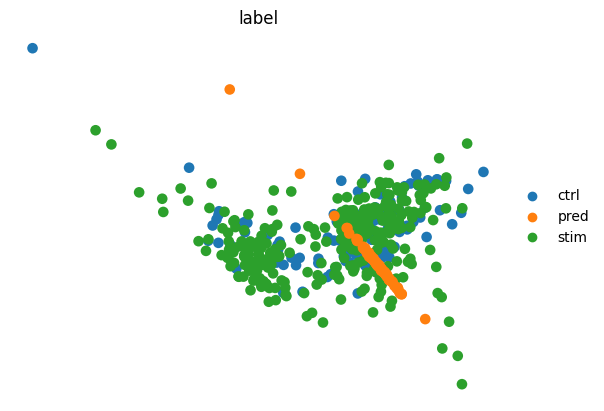

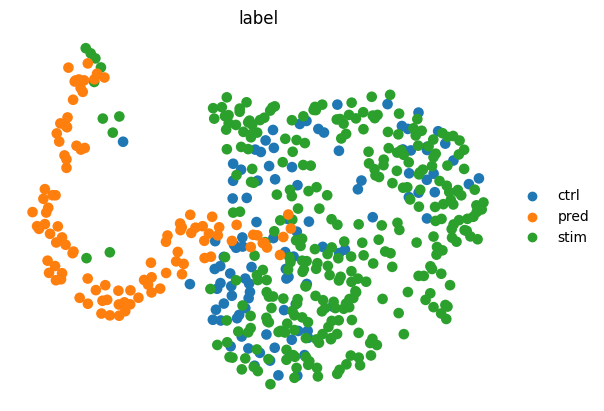

Running DE with method: t-test
('stim',)
('pred',)
100 genes used (union of top-100 DEGs from all methods)
Top 100 stim vs ctrl DE genes:
  ['Junb', 'Tpt1', 'Rtn1', '1190002H23Rik', 'Ier2', 'Lrg1', 'Zbtb16', 'Tubb4b', 'Tmem176b', 'Clta', 'Vwf', 'Mrps15', 'Rheb', 'Ier3', 'Ubtd1', 'Zbtb22', 'Cox5a', 'Dnajb5', 'Vsnl1', 'Ptgfrn', '2310036O22Rik', '2700060E02Rik', 'Galntl2', 'Slc35d1', 'Snf8', 'Lcn2', 'AI593442', 'Atxn7l3b', 'Slc3a2', 'Npdc1', 'Apobec3', 'Sptlc2', 'Gmpr', 'Samd4', 'Zcchc18', 'Ch25h', 'Lyl1', 'Fam107a', 'Arrb1', 'Ecscr', 'Rtkn', 'Fmo2', 'Mrfap1', 'E030010A14Rik', 'Tmem93', 'Crlf2', 'Scarb2', 'Ppp2r5b', 'Osgin2', 'Osmr', 'Cmbl', 'Dhrs3', 'Nrn1', 'Tnik', 'Apoe', 'Ostf1', 'Zfp386', 'Mapt', 'Cck', 'Tmem70', 'Atf3', 'Fth1', 'Prdm4', 'Slc25a23', 'Tmem59l', 'Cxcl1', 'Map3k6', 'Bola3', 'Ctgf', 'Rab11a', 'Tgm2', 'Akt2', 'Tmem176a', '1700026J04Rik', 'Med19', 'Atp2b2', 'Rasgrp1', 'Kcnb1', 'Khdrbs3', 'Slc39a1', 'Znrd1as', 'Usp38', 'Fos', 'Slc35b3', 'Bcs1l', 'Rdh10', 'Bai2', 'Nap1l5', '6

/usr/local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


Testing OPC
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 5/5: 100%|██████████| 5/5 [01:08<00:00, 13.26s/it, train_loss_step=2.27e+4, train_loss_epoch=3.55e+4]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [01:08<00:00, 13.70s/it, train_loss_step=2.27e+4, train_loss_epoch=3.55e+4]


/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/tmp/ipykernel_497/2554641053.py:35: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  eval_adata = ctrl.concatenate(stim, pred)
/usr/local/lib/python3.10/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


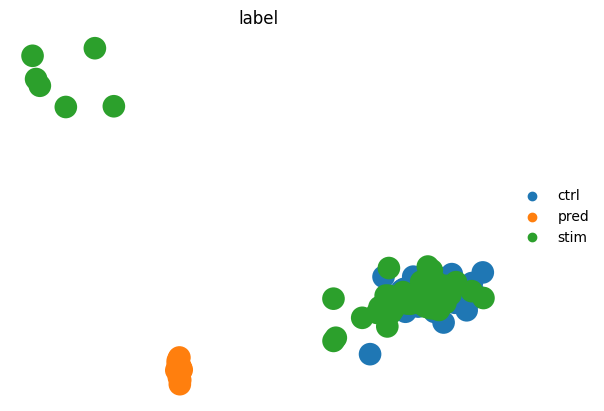

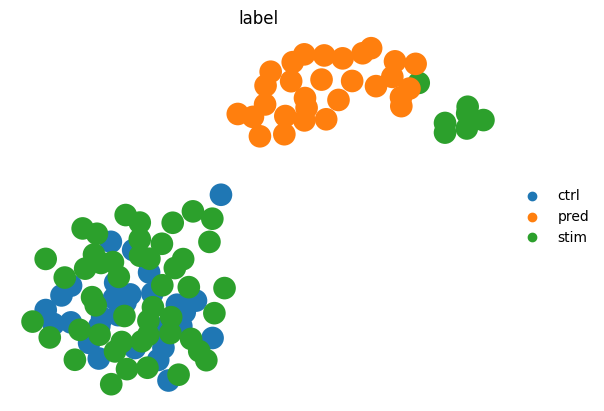

Running DE with method: t-test
('stim',)
('pred',)
100 genes used (union of top-100 DEGs from all methods)
Top 100 stim vs ctrl DE genes:
  ['Ube2n', 'Xrcc6', '1700025K23Rik', 'Klf6', 'Rab2b', 'Pkig', 'Ttll1', 'Man2b1', 'Mus81', 'Lphn1', 'Dnttip2', 'Ruvbl2', 'Adam10', 'Tbc1d19', 'Smad5', 'Napb', 'Zdhhc4', 'Lasp1', 'BC005537', 'Cyb5r3', 'Dnajb1', 'Lphn3', 'Nrgn', 'Zfp687', '3200002M19Rik', 'Jmjd6', 'Gnpda1', '9430016H08Rik', 'Rars2', 'Mthfd1', 'Scamp2', '4931406C07Rik', 'Aaas', 'Mfsd5', 'Dmtf1', 'Mtap7d2', 'Mfsd10', 'Tcf3', 'Dzip3', 'Plk1s1', 'Lancl1', 'Pls3', 'Xpo7', 'Itgb3bp', 'Dmxl2', 'B3galtl', 'Lysmd1', 'Wdr12', 'Lyrm4', 'Rpusd3', 'Vps52', 'Cc2d2a', 'A630007B06Rik', 'Cep57', 'Fbl', 'Ppid', 'Ppan', 'Ddx3x', 'Enoph1', 'Rmi1', 'Zfp36', 'Eya1', 'Arhgap32', 'Adck3', '2700007P21Rik', 'Etv3', 'Lpp', 'Usp4', 'Phf8', 'Ppp4r1', 'Ufsp2', 'E2f5', 'Ccnc', 'Rab39b', 'Sat1', 'Srxn1', 'Pcf11', 'Ninj1', 'Ric8', 'Zfp120', 'Tmub2', 'Ncaph2', 'Rgs2', 'Trim44', 'Nsd1', 'Dmd', 'Set', 'Dnajc4', 'Nelf', '

/usr/local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


Testing NF Oligo
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 5/5: 100%|██████████| 5/5 [01:10<00:00, 13.47s/it, train_loss_step=1.22e+4, train_loss_epoch=3.59e+4]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [01:10<00:00, 14.05s/it, train_loss_step=1.22e+4, train_loss_epoch=3.59e+4]


/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/tmp/ipykernel_497/2554641053.py:35: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  eval_adata = ctrl.concatenate(stim, pred)
/usr/local/lib/python3.10/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


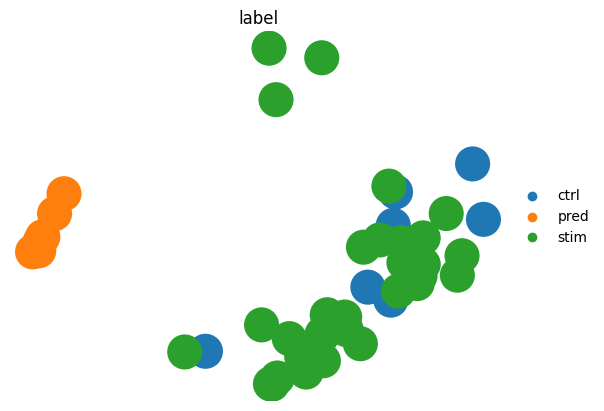

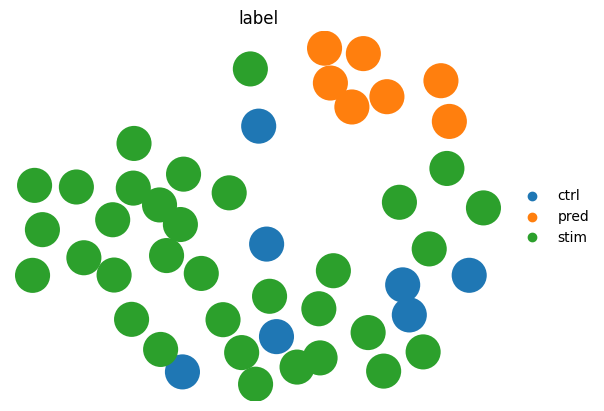

Running DE with method: t-test
('stim',)
('pred',)
100 genes used (union of top-100 DEGs from all methods)
Top 100 stim vs ctrl DE genes:
  ['Slc3a2', 'Uba3', 'Bex4', 'Zfp326', 'Tia1', 'Hmgcl', 'Hnrnph3', 'Lpcat2', 'N4bp2l2', 'Nfia', 'Lass5', 'Pcmtd1', 'Fam54b', 'Wdr18', 'Enpp5', 'Bex1', 'Hdgfrp2', 'Chd4', 'Ppp2r3a', 'Mrpl11', 'Aprt', 'Rwdd1', 'Glrx2', 'Gnpda2', 'Pllp', '0610007P22Rik', 'Magohb', 'Cdipt', 'Spon1', 'Map6d1', 'Gm17451', 'Sgcb', 'Ogfr', 'Itch', 'Osgep', 'Ccdc28b', 'Ldha', 'Fam188a', 'Stmn1', 'Sept3', 'Taf9b', 'Ubxn4', 'Armcx5', 'Cox19', 'Tfpt', 'Lpin1', 'Actr8', 'Ing1', 'Gtf3c6', 'Nsd1', 'Kif21b', 'Zc3h11a', 'Pcp4', 'Ppp5c', 'Tmem141', 'Usp3', 'Serbp1', 'Surf1', 'Mesdc2', 'Dnajc30', 'Car11', 'Eif2a', 'Nob1', 'Bfar', 'Arf3', '1110065P20Rik', 'Vapb', 'Pdcl', 'Ccny', 'Afap1', 'Lias', 'Egr1', 'S100a16', 'Dnajc11', 'Mllt10', 'Mnat1', 'Cdk11b', 'Dlat', 'Cenpq', 'Usp9x', 'Ly6h', 'Eftud2', 'Dnmt1', 'Wrb', 'Vrk3', 'Vsnl1', 'Ubqln1', 'Cxx1a', 'Fasn', 'Gtf2h2', 'Mrps26', 'Trabd', 'Y

/usr/local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


In [17]:
# === Main loop ======================================================================================================================================
t0 = time.perf_counter()
results = []

for cell_type in norm_data.obs[celltype_col].unique():
    counts = norm_data.obs['label'][norm_data.obs[celltype_col] == cell_type].value_counts()
    if counts.get('stim', 0) < 3 or counts.get('ctrl', 0) < 3:
        print(f"Skipping {cell_type}: too few cells (stim={counts.get('stim',0)}, ctrl={counts.get('ctrl',0)})")
        continue

    print(f"Testing {cell_type}")
    train_adata = norm_data[~((norm_data.obs[celltype_col] == cell_type) & (norm_data.obs['label']=="stim"))].copy()
    if USE_CSR and sparse.issparse(train_adata.X):
        train_adata.X = train_adata.X.tocsr()

    pt.tl.Scgen.setup_anndata(train_adata, batch_key='label', labels_key=celltype_col)
    model = pt.tl.Scgen(train_adata)
    #######################################################################################################################
    model.train(max_epochs=5, 
                batch_size=32, 
                early_stopping=True, 
                accelerator="cpu", 
                devices=1, 
                deterministic=args.deterministic, 
                enable_checkpointing=False, 
                enable_model_summary=False, 
                logger=False)

    
    pred, _ = model.predict(ctrl_key='ctrl', stim_key='stim', celltype_to_predict=cell_type)
    pred.obs['label'] = 'pred'

    ctrl = norm_data[(norm_data.obs[celltype_col]==cell_type) & (norm_data.obs['label']=="ctrl")]
    stim = norm_data[(norm_data.obs[celltype_col]==cell_type) & (norm_data.obs['label']=="stim")]
    eval_adata = ctrl.concatenate(stim, pred)
    eval_adata.obs['label'] = eval_adata.obs['label'].astype('category').cat.remove_unused_categories()

    try:
        sc.tl.pca(eval_adata)
        sc.pp.neighbors(eval_adata)
        sc.tl.umap(eval_adata)
    except Exception as e:
        print(f"Skipping {cell_type}: PCA/UMAP failed with {e}")
        continue

    sc.pl.pca(eval_adata, color='label', frameon=False, save=f"_{cell_type}_pca.png")
    sc.pl.umap(eval_adata, color='label', frameon=False, save=f"_{cell_type}_umap.png")

    X_full = eval_adata.X.toarray() if sparse.issparse(eval_adata.X) else eval_adata.X
    pca_full = eval_adata.obsm['X_pca']
    masks = {k: eval_adata.obs['label']==k for k in ['ctrl','stim','pred']}

    from collections import Counter
    stim_vote_counter = Counter()
    stim_lfc_dict = {}
    pred_lfc_dict = {}
    
    for method in args.de_methods:
        print(f"Running DE with method: {method}")
        # Stim vs Ctrl
        sc.tl.rank_genes_groups(
            eval_adata,
            groupby="label",
            reference="ctrl",
            groups=["stim"],
            method=method,
            n_genes=eval_adata.n_vars
        )
        print(eval_adata.uns["rank_genes_groups"]["names"].dtype.names)
        stim_genes = eval_adata.uns['rank_genes_groups']['names']['stim'][:K].tolist()
        de_key = "logfoldchanges"
        if "logfoldchanges" not in eval_adata.uns["rank_genes_groups"]:
            if "scores" in eval_adata.uns["rank_genes_groups"]:
                de_key = "scores"
            else:
                raise ValueError("No logfoldchanges or scores found in rank_gene_groups result")
        stim_lfc = eval_adata.uns["rank_genes_groups"][de_key]["stim"][:K].tolist()
        stim_vote_counter.update(stim_genes)
        stim_lfc_dict.update(dict(zip(stim_genes, stim_lfc)))

        sc.tl.rank_genes_groups(
            eval_adata,
            groupby="label",
            reference="ctrl",
            groups=["pred"],
            method=method,
            n_genes=eval_adata.n_vars
        )
        print(eval_adata.uns["rank_genes_groups"]["names"].dtype.names)
        pred_genes = eval_adata.uns['rank_genes_groups']['names']['pred'][:K].tolist()
        de_key = "logfoldchanges"
        if "logfoldchanges" not in eval_adata.uns["rank_genes_groups"]:
            if "scores" in eval_adata.uns["rank_genes_groups"]:
                de_key = "scores"
            else:
                raise ValueError("No logfoldchanges or scores found in rank_gene_groups result")
        pred_lfc = eval_adata.uns["rank_genes_groups"][de_key]["pred"][:K].tolist()
        pred_lfc_dict.update(dict(zip(pred_genes, pred_lfc)))

        stim_de = list(stim_vote_counter.keys())  # all genes considered DE across methods for stim
        pred_de = list(pred_lfc_dict.keys())      # all genes with pred LFCs collected

  # Step 5: majority vote or union
    if args.de_majority_vote:
        required_votes = (len(args.de_methods) + 1) // 2
        selected_genes = [g for g, count in stim_vote_counter.items() if count >= required_votes]
        print(f"{len(selected_genes)} genes passed majority vote (≥{required_votes}/{len(args.de_methods)})")
        gene_set_label = f"majority_top{K}_DEGs"
    else:
        selected_genes = sorted(set(stim_vote_counter))
        print(f"{len(selected_genes)} genes used (union of top-{K} DEGs from all methods)")
        gene_set_label = f"union_top{K}_DEGs"

    # --- compute overlap and Jaccard ---
    shared = set(stim_de).intersection(pred_de)
    jaccard = len(shared) / (len(stim_de) + len(pred_de) - len(shared)) if (stim_de or pred_de) else 0

    print(f"Top {K} stim vs ctrl DE genes:\n  {stim_de}")
    print(f"Top {K} pred vs ctrl DE genes:\n  {pred_de}")
    print(f"Shared ({len(shared)} genes):\n  {sorted(shared)}")
    print(f"Jaccard index = {jaccard:.3f}")

        # --- metrics loop ---
        # --- metrics loop ---
    for label_name, (X_mat, pca_coords) in [
        ('all_genes', (X_full, pca_full)),
        (gene_set_label, (
            X_full[:, [eval_adata.var_names.get_loc(g) for g in selected_genes]],
            PCA().fit_transform(X_full[:, [eval_adata.var_names.get_loc(g) for g in selected_genes]])
        ))
    ]:
        boot_stats   = bootstrap_metrics(X_mat, masks['stim'], masks['pred'], pca_coords)
        dist_scaled  = compute_dist_scaled(X_mat, masks['ctrl'], masks['stim'], masks['pred'])
        kde_dist     = mean_var_kde_distance(X_mat[masks['stim']], X_mat[masks['pred']])

        combined = masks['stim'] | masks['pred']
        lbls     = eval_adata.obs['label'][combined].map({'stim':1,'pred':0}).values
        emb      = pca_full[combined]
        sil      = silhouette_score(emb, lbls)
        clf      = LogisticRegression(max_iter=1000)
        clf.fit(emb, lbls)
        auc      = roc_auc_score(lbls, clf.predict_proba(emb)[:,1])

        if label_name == gene_set_label:
            # build lookup dicts from the lists you saved earlier
            stim_lfc_dict = dict(zip(stim_de, stim_lfc))
            pred_lfc_dict = dict(zip(pred_de, pred_lfc))
            shared = set(stim_de).intersection(pred_de)
            if shared:
                true_vals = []
                pred_vals = []
                for g in shared:
                    if g in stim_lfc_dict and g in pred_lfc_dict:
                        true_vals.append(stim_lfc_dict[g])
                        pred_vals.append(pred_lfc_dict[g])
                lfc_corr = np.corrcoef(true_vals, pred_vals)[0, 1] if len(true_vals) > 1 else np.nan
            else:
                lfc_corr = np.nan

            j_top = jaccard
        else:
            lfc_corr, j_top = np.nan, np.nan
            
        results.append({
            'cell_type': cell_type,
            'gene_set': label_name,
            'de_method': "+".join(args.de_methods),
            'jaccard_topK': j_top,
            'dist_scaled': dist_scaled,
            'mean_var_distn': kde_dist,
            'lfc_corr': lfc_corr,
            'silhouette': sil,
            'auc': auc,
            **boot_stats
        })

In [18]:
# Finish timing
end_time = time.perf_counter()
print(f"Total time: {end_time - t0:.2f}s")

Total time: 706.25s


In [19]:
# Compile & save
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(outdir, "results_internal_benchmarking.csv"), index=False)
print(results_df)

     cell_type           gene_set de_method  jaccard_topK  dist_scaled  \
0   Excitatory          all_genes    t-test           NaN     3.297626   
1   Excitatory  union_top100_DEGs    t-test      0.000000     1.814255   
2        Oligo          all_genes    t-test           NaN     1.515874   
3        Oligo  union_top100_DEGs    t-test      0.010101     1.139331   
4        Astro          all_genes    t-test           NaN     1.644446   
5        Astro  union_top100_DEGs    t-test      0.015228     0.653905   
6    Microglia          all_genes    t-test           NaN     1.302356   
7    Microglia  union_top100_DEGs    t-test      0.000000     1.193423   
8   Inhibitory          all_genes    t-test           NaN     1.304472   
9   Inhibitory  union_top100_DEGs    t-test      0.015228     0.596250   
10        Endo          all_genes    t-test           NaN     1.403968   
11        Endo  union_top100_DEGs    t-test      0.005025     1.377186   
12         OPC          all_genes    t

In [ ]:
# Plot summary
metrics = [
    ("R2_mean","R2_std"),("MSE_mean","MSE_std"),("RMSE_mean","RMSE_std"),("MAE_mean","MAE_std"),
    ("Pearson_mean","Pearson_std"),("Cosine_mean","Cosine_std"),("Edist_mean","Edist_std"),
    ("MMD_mean","MMD_std"),("Euc_mean","Euc_std"),("jaccard_topK",None),("silhouette",None),("auc",None)
]

cell_types = sorted(results_df['cell_type'].unique())
gene_sets = sorted(results_df['gene_set'].unique())

x = np.arange(len(cell_types))
bar_width = 0.4 if len(gene_sets) == 1 else 0.4 / len(gene_sets)
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20,12))
axes = axes.ravel()

for ax, (mean_col, std_col) in zip(axes, metrics):
    for i, gs in enumerate(gene_sets):
        sub = results_df[results_df['gene_set'] == gs]
        grouped = sub.set_index('cell_type').sort_index()

        y = grouped[mean_col].reindex(cell_types).values
        yerr = grouped[std_col].reindex(cell_types).values if std_col else None

        ax.bar(
            x + i * bar_width,
            y,
            bar_width,
            yerr=yerr,
            capsize=3,
            label=gs
        )
    ax.set_xticks(x + (len(gene_sets)-1)*bar_width / 2)
    ax.set_xticklabels(cell_types, rotation=45, ha='right')
    ax.set_title(mean_col.replace('_mean',''))
for ax in axes[len(metrics):]:
    ax.axis('off')
handles, labels = axes[0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='center right')
fig.tight_layout(rect=[0,0,0.85,1])
fig.savefig(os.path.join(figdir, "metrics_summary.png"), bbox_inches='tight', dpi=300)
plt.show()